# Experimentation on reinforcement learning

* [Hub of related tutorials](https://www.gymlibrary.dev/content/tutorials/)
* [Tutorial on OpenAI Gym](https://blog.paperspace.com/getting-started-with-openai-gym/)
* [Q-learning](https://www.gocoder.one/blog/rl-tutorial-with-openai-gym)

## Imports & configuration

In [5]:
# Configuration for execution & environment visualization in Google Colab
!pip install stable_baselines3 gym pygame
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet==1.5.27 > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from pyvirtualdisplay import Display
import random

In [7]:
%matplotlib inline

# Virtual display for visualization in Google Colab
display = Display(visible=0, size=(400, 300))
display.start()

## Setting up the environment

We use the [Gym Cart Pole environment](https://www.gymlibrary.dev/environments/classic_control/cart_pole/), and prepare helper functions to visualize a state and to run a testing loop on the environment.

In [8]:
ENV_NAME = 'CartPole-v1'
env = gym.make(ENV_NAME)
env.action_space.seed(42)
observation = env.reset()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  class ObservationWrapper(Wrapper):
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.re

In [9]:
def render_env(env):
    clear_output(wait=True)
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()

In [10]:
def test_agent(env, agent=env.action_space.sample(), agent_uses_observation=True, nb_episodes=10, visualize_process=False):
  """
  Agent testing loop.
  Args:
    env: the environment
    agent: function to call to select the next action (defaults to a random agent)
    agent_uses_observation: True if the current observation should be passed to the agent as an argument
    nb_episodes: number of episodes to run (defaults to 10)
    visualize_process: if True, every observation will be rendered to observe the real-time behavior of the agent
  """
  summary = ''
  scores = []

  for episode in range(1, 1+nb_episodes):
      score = 0
      steps = 0
      obs = env.reset()
      done = False
      action = None
      if visualize_process:
        render_env(env)
      
      while not done:
          steps += 1
          if agent_uses_observation:
            action, _ = agent(obs)
          else:
            action = agent() 
          obs, reward, done, _ = env.step(action)
          score += reward
          if visualize_process:
              render_env(env)
              print(summary)
      episode_summary = f'Score of episode {episode}: {score}'            
      summary += episode_summary + '\n'
      scores.append(score)
      if not visualize_process:
          print(episode_summary)
  print(f'Average score on {nb_episodes} episodes: {np.mean(np.array(scores))}')

## Performance of a random agent

Before training reinforcement-learning algorithms, we observe the behavior and perofrmance of an agent taking a random possible action at every state.

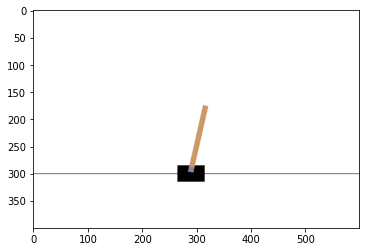

Score of episode 1: 21.0
Score of episode 2: 31.0
Score of episode 3: 18.0
Score of episode 4: 15.0
Score of episode 5: 35.0
Score of episode 6: 14.0
Score of episode 7: 12.0
Score of episode 8: 31.0
Score of episode 9: 22.0

Average score on 10 episodes: 22.5


In [11]:
VISUALIZE_PROCESS = True # True to observe the real-time behavior
test_agent(env, agent=env.action_space.sample, agent_uses_observation=False, visualize_process=VISUALIZE_PROCESS)

## Performance of a Q-learning agent
📚 **Resources:**
* [Q-learning in a gym environment](https://www.gocoder.one/blog/rl-tutorial-with-openai-gym)
* [Similar article](https://medium.com/swlh/using-q-learning-for-openais-cartpole-v1-4a216ef237df)


 💡 Q is for quality (how valuable an action is in the current state). Q-table: 1 row per state, 1 row per action to take, `q-table[state][action]` stores the Q-value for taking that action in the state. We look for a pair `(S,A)` that maximizes `Q(S,A)`. 

 We update the Q-value after taking an action in a state following $Q(S_t, A_t) = Q(S_t, A_t) + \alpha [R_{t+1} + \gamma max_{\alpha} Q(S_{t+1}, a) - Q(S_t, A_t)]$ 


With $\alpha$ the learning rate, $R_{t+1}$ the reward, $\gamma$ the discount factor and $max_{\alpha} Q(S_{t+1}, a)$ the maximum expected future reward.

The higher the learning rate $\alpha$, the easier the agent learns new information over learnt one.

The higher the discount factor $\gamma$, the more the agent takes the delayed reward into account over immediate reward (important in environments where reward is not given after every action i.e. taxi environment).

$\epsilon$ is the initial chance to take a random action for exploration. We initialize it with a high value, and it reduces by a decay rate after every episode.

### Implementing a Q-learning agent

In [35]:
class QAgent:
  def __init__(self, env):
    #self.state_size = env.observation_space.n
    self.action_size = env.action_space.n 
    self.Observation = [30, 30, 50, 50] # first 2 vars  cart (pos/velocity) not as important as pole ones
    self.np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1]) # steps based upon cart pos., cart vel. etc
    self.qtable = np.zeros((self.Observation + [self.action_size])) # initially all Q-values are 0


  def __get_discrete_state(self, state):
    discrete_state = state/self.np_array_win_size+np.array([15,10,1,10])
    return tuple(discrete_state.astype(int))
  
  def learn(self, env, learning_rate=0.9, discount_rate=0, epsilon=1, decay_rate=0.005, num_episodes=1000, max_steps_per_ep=100):
    for episode in range(num_episodes):
      state = self.__get_discrete_state(env.reset())
      done = False

      for s in range(max_steps_per_ep):
        # 1. Take an action
        if random.uniform(0, 1) < epsilon: # exploration
          action = env.action_space.sample()
        else: # exploitation
          action = np.argmax(self.qtable[state]) # action that maximizes Q in current state
        
        # 2. Observe the reward
        new_state, reward, done, _ = env.step(action)
        new_state = self.__get_discrete_state(new_state)

        # 3. Update Q-table (cf. equation above)
        self.qtable[state + (action,)] = self.qtable[state + (action,)] + learning_rate * (reward + discount_rate * np.max(self.qtable[new_state]) - self.qtable[state + (action,)])

        # 4. Update episode state
        state = new_state
        if done:
          break
      
      # At the end of an episode, we decrease epsilon for more exploitation
      epsilon = np.exp(-decay_rate * episode)
    print(f'Trained over {num_episodes}.')

  def predict(self, observation):
    discr_obs = self.__get_discrete_state(observation)
    action = np.argmax(self.qtable[discr_obs])
    return (action, None)

### Training the Q-learning agent

In [52]:
model = QAgent(env)
model.learn(env, learning_rate=0.1, discount_rate=0.95, epsilon=1, 
            decay_rate=0.0005, num_episodes=10000, max_steps_per_ep=500) 

Trained over 10000.


### Evaluating the Q-learning agent

In [55]:
VISUALIZE_PROCESS = False # True to observe the real-time evolution
test_agent(env, agent=model.predict, visualize_process=VISUALIZE_PROCESS)

Score of episode 1: 147.0
Score of episode 2: 500.0
Score of episode 3: 100.0
Score of episode 4: 257.0
Score of episode 5: 76.0
Score of episode 6: 123.0
Score of episode 7: 125.0
Score of episode 8: 105.0
Score of episode 9: 200.0
Score of episode 10: 121.0
Average score on 10 episodes: 175.4


Significantly better than a random agent (about 170 in average against about 20), very fast to train due to simplicity, though it doesn't master the task as well as deep learning RL algos.

## Performance of a PPO agent
📚 **Resources:**
* [Proximal Policy Optimization introduction by OpenAI](https://openai.com/blog/openai-baselines-ppo/)
* [PPO: Intuition & explanation](https://jonathan-hui.medium.com/rl-proximal-policy-optimization-ppo-explained-77f014ec3f12) / [Similar HuggingFace alternative](https://huggingface.co/blog/deep-rl-ppo)


**Policy gradient methods**: state-of-the-art RL methods using deep NNs. Great results, but:
  * Sensitive to the step size choice: *small makes it slow, large leads to poor performance or sensitivity to noise.*
  * Poor sample efficiency: *millions or more timesteps often necessary for simple tasks.* 

➡️ **PPO limits these flaws by formalizing the constraint as a penalty in the cost function rather than imposing a hard constraint**. This simplifies computation and optimization through gradient descent tremendously.

### Training a PPO agent

In [15]:
env_ppo = make_vec_env(ENV_NAME, n_envs=1)

model = PPO("MlpPolicy", env_ppo, verbose=1)
model.learn(total_timesteps=100000)
model.save(f"PPO_{ENV_NAME}")
del model

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  class ObservationWrapper(Wrapper):
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.re

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.9     |
|    ep_rew_mean     | 21.9     |
| time/              |          |
|    fps             | 1363     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 26.8       |
|    ep_rew_mean          | 26.8       |
| time/                   |            |
|    fps                  | 1000       |
|    iterations           | 2          |
|    time_elapsed         | 4          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00808142 |
|    clip_fraction        | 0.0975     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.686     |
|    explained_variance   | -0.000438  |
|    learning_rate        | 

A mean episode length of 500 (the upper limit for this problem) is obtained between 75k and 76k steps.

### Evaluating the PPO agent

In [16]:
VISUALIZE_PROCESS = False # True to observe the real-time evolution
model = PPO.load(f"PPO_{ENV_NAME}")
test_agent(env_ppo, agent=model.predict, visualize_process=VISUALIZE_PROCESS)

Score of episode 1: [500.]
Score of episode 2: [500.]
Score of episode 3: [500.]
Score of episode 4: [500.]
Score of episode 5: [500.]
Score of episode 6: [500.]
Score of episode 7: [500.]
Score of episode 8: [500.]
Score of episode 9: [500.]
Score of episode 10: [500.]
Average score on 10 episodes: 500.0


The resulting agent seems to master the task, always obtaining a score of 500 (the upper limit), which is a significant improvement in comparison to the random agent with an average score of about 20 on 10 episodes.

## Performance of an A2C agent

### Training an A2C agent

In [12]:
env_a2c = make_vec_env(ENV_NAME, n_envs=1)

model = A2C("MlpPolicy", env_a2c, verbose=1)
model.learn(total_timesteps=100000)
model.save(f"A2C_{ENV_NAME}")
del model

Using cpu device


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  class ObservationWrapper(Wrapper):
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.re

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 38.3     |
|    ep_rew_mean        | 38.3     |
| time/                 |          |
|    fps                | 551      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.627   |
|    explained_variance | -0.289   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.38     |
|    value_loss         | 14       |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 42.2     |
|    ep_rew_mean        | 42.2     |
| time/                 |          |
|    fps                | 509      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|

### Evaluating the A2C agent

In [14]:
VISUALIZE_PROCESS = False # True to observe the real-time evolution
model = A2C.load(f"A2C_{ENV_NAME}")
test_agent(env_a2c, agent=model.predict, visualize_process=VISUALIZE_PROCESS)

Score of episode 1: [314.]
Score of episode 2: [319.]
Score of episode 3: [299.]
Score of episode 4: [315.]
Score of episode 5: [323.]
Score of episode 6: [314.]
Score of episode 7: [315.]
Score of episode 8: [295.]
Score of episode 9: [306.]
Score of episode 10: [303.]
Average score on 10 episodes: 310.29998779296875


Learns faster than PPO on the same amount of episodes. Outperforms Q-learning, but doesn't perform as good as PPO with the same number of learning episodes(avg. 500).  

## Cleaning up environments

In [ ]:
env.close()
env_ppo.close()